In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set plotting style
sns.set(style="whitegrid")

1. Exploratory Data Analysis

In [19]:
# Load and inspect data
df = pd.read_csv('../data/trading_summary.csv', parse_dates=['Date'], index_col='Date')
print(df.head())
print("\nData description:")
print(df.describe())

            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  

Data description:
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5645.000000     63.609130     72.026945     72.503100     71.665079   
std     3259.575279     52.266247     51.259828   

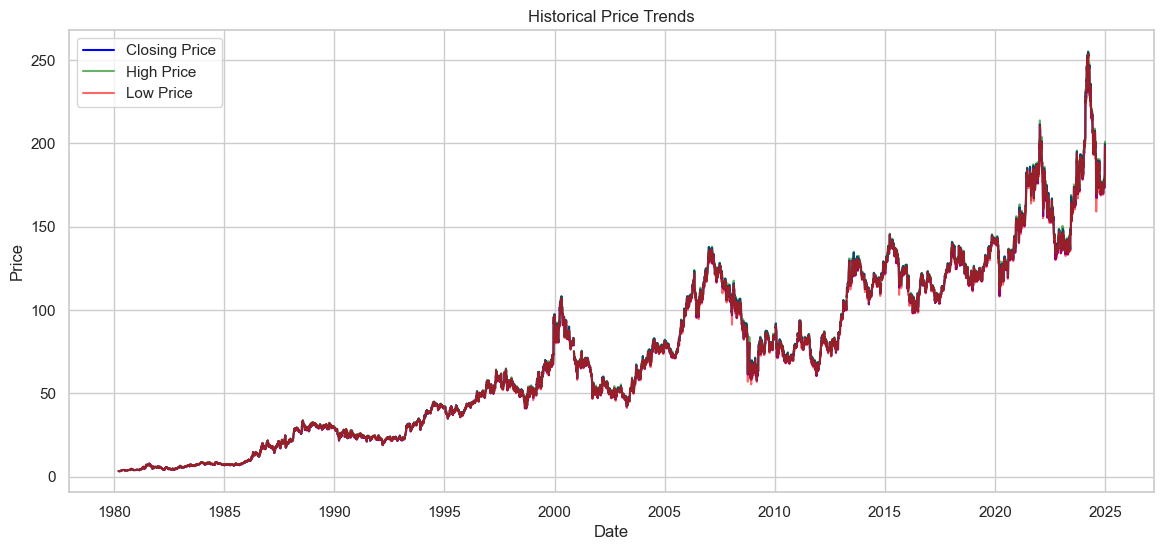

In [22]:
# Plot price trends
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['High'], label='High Price', alpha=0.6, color='green')
plt.plot(df['Low'], label='Low Price', alpha=0.6, color='red')
plt.title('Historical Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

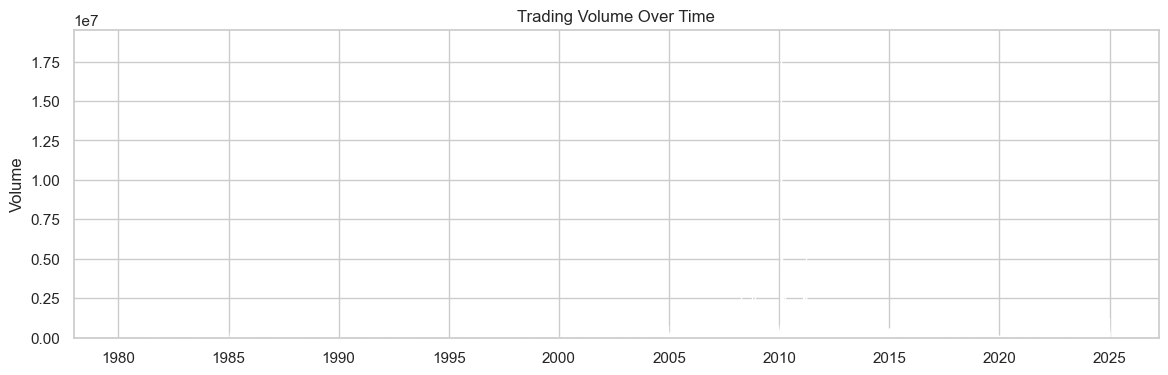

In [23]:
# Volume analysis
plt.figure(figsize=(14, 4))
plt.bar(df.index, df['Volume'], color='orange')
plt.title('Trading Volume Over Time')
plt.ylabel('Volume')
plt.show()

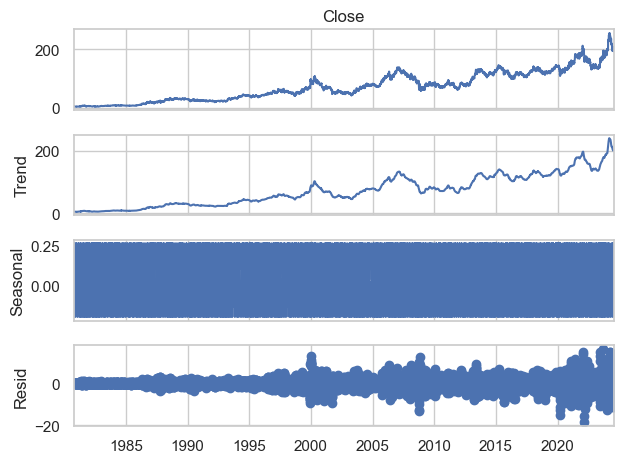

In [42]:
# Seasonal decomposition
result = seasonal_decompose(df['Close'].ffill(), period=30, model='additive')
result.plot()
plt.tight_layout()
plt.show()

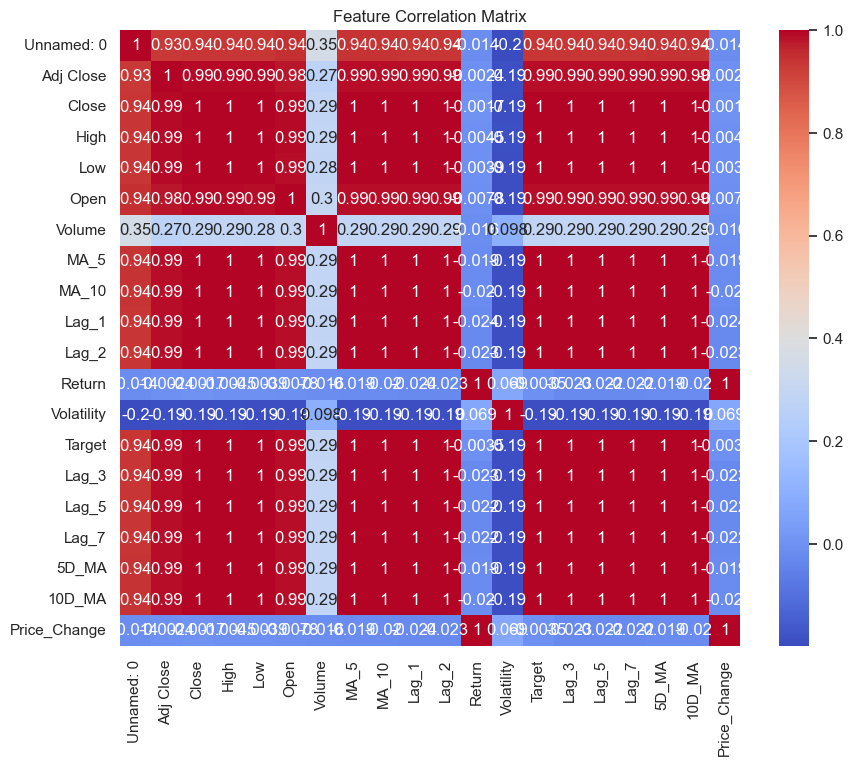

In [43]:
# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

2. Feature Engineering & Preprocessing

In [59]:
# # Create technical indicators
# df['5D_MA'] = df['Close'].rolling(window=5).mean()
# df['10D_MA'] = df['Close'].rolling(window=10).mean()
# df['Price_Change'] = df['Close'].pct_change()
# df['Volatility'] = df['Close'].rolling(window=5).std()

# # Create lag features
# for lag in [1, 3, 5, 7]:
#     df[f'Lag_{lag}'] = df['Close'].shift(lag)

# # Create target variable (5-day future price)
# df['Target'] = df['Close'].shift(-5)

# # Drop missing values
# df.dropna(inplace=True)

# # Split data
# features = ['Close', '5D_MA', '10D_MA', 'Price_Change', 'Volatility', 
#            'Lag_1', 'Lag_3', 'Lag_5', 'Volume']
# target = 'Target'

# split_idx = int(len(df) * 0.8)
# train = df.iloc[:split_idx]
# test = df.iloc[split_idx:]

# # Scale features
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train[features])
# test_scaled = scaler.transform(test[features])

# Create moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Create lag features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)

# Calculate daily returns and volatility (rolling 5-day std of returns)
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=5).std()

# Create target variable: closing price 5 trading days into the future
df['Target'] = df['Close'].shift(-5)

# Drop rows with NaN values generated by rolling and shifting operations
df.dropna(inplace=True)
print("\nData after feature engineering:")
print(df.head())


Data after feature engineering:
            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-12-09         185   2.764560  3.961514  3.989610  3.961514  0.000000   
1980-12-10         186   2.774363  3.975562  3.989610  3.975562  0.000000   
1980-12-11         187   2.754756  3.947466  3.989610  3.947466  0.000000   
1980-12-12         188   2.754756  3.947466  3.947466  3.947466  3.947466   
1980-12-15         189   2.784167  3.989610  4.017706  3.989610  0.000000   

            Volume      MA_5     MA_10     Lag_1     Lag_2    Return  \
Date                                                                   
1980-12-09  2669.0  3.939037  3.924989  4.017706  3.933418 -0.013986   
1980-12-10  6229.0  3.955895  3.929204  3.961514  4.017706  0.003546   
1980-12-11  1780.0  3.967133  3.932013  3.975562  3.961514 -0.007067   
1980-12-12     0.0  3.969943  3.934823  3.947466  3.975562  0.00000

3. Model Development

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Split data
features = ['Close', 'MA_5', 'MA_10', 'Lag_1', 'Lag_2', 'Volatility']
X = df[features]
y = df['Target']

# Split the data into training (80%) and testing (20%) sets
train_size = int(0.8 * len(df))
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

In [64]:
# Scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

In [65]:
# Create sequences
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data)-n_steps-5):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+5, 0])  # First column is Close price
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [67]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [68]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)



Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0189 - mae: 0.0762 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0021 - mae: 0.0291 - val_loss: 0.0010 - val_mae: 0.0246
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0017 - mae: 0.0266 - val_loss: 8.7453e-04 - val_mae: 0.0224
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0013 - mae: 0.0235 - val_loss: 0.0013 - val_mae: 0.0286
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0010 - val_mae: 0.0243
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 8.9999e-04 - mae: 0.0200 - val_loss: 0.0019 - val_mae: 0.0366
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 8.9566e-04 - mae: 0.0201 - val_loss: 0.0026 - val_mae: 0.0440
Epoch 8/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 9.4871e-04 - mae: 0.0207 - val_loss: 0.0025 - val_mae: 0.0432
Epoch 9/100
186/186 ━━━━

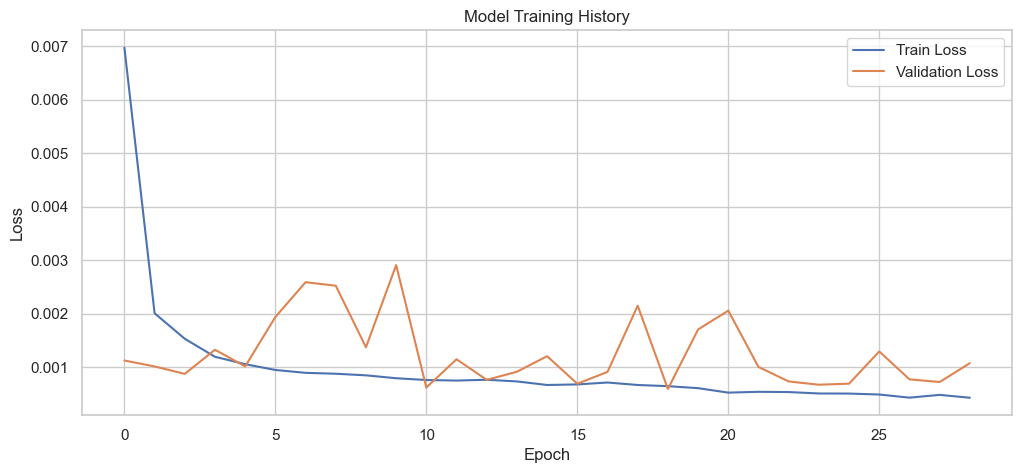

In [69]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save model
model.save('../models/lstm_model1.h5')

4. Evaluation & Predictions

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE: 7.68
MAE: 5.06
Predictions saved to predictions.csv


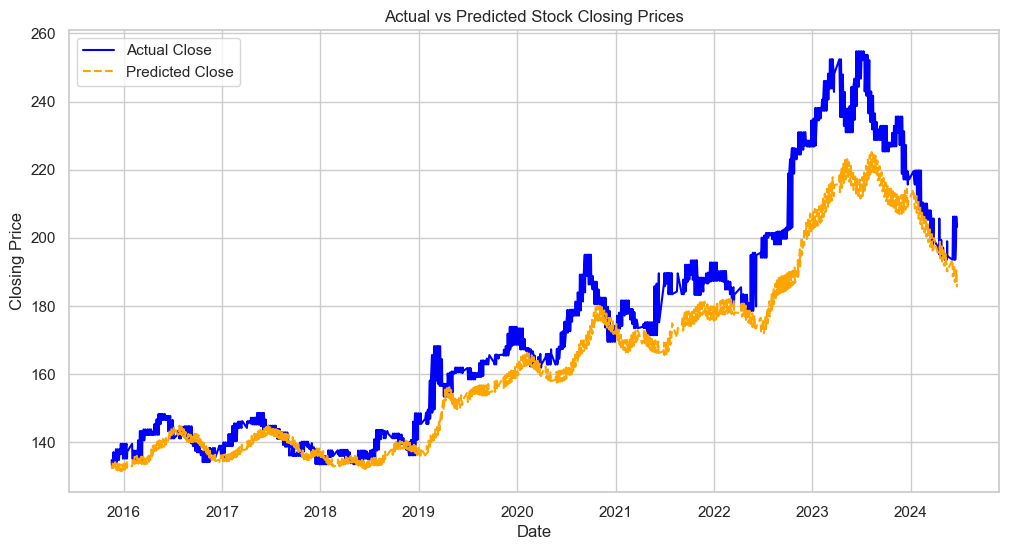

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions
y_pred = model.predict(X_test)

# Inverse scaling
scaler_target = MinMaxScaler()
scaler_target.fit(train[['Close']])

y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Save predictions
pred_dates = test.index[30+5:-5]
# results = pd.DataFrame({
#     'Date': pred_dates,
#     'Actual': y_test_inv.flatten(),
#     'Predicted': y_pred_inv.flatten()
# })
y_test_trimmed = y_test_inv[-len(pred_dates):].flatten()
y_pred_trimmed = y_pred_inv[-len(pred_dates):].flatten()


predictions = pd.DataFrame({
    'Date': pred_dates,
    'Actual_Close': y_test_trimmed,
    'Predicted_Close': y_pred_trimmed
})
predictions.to_csv('../data/predictions.csv', index=False)
print("Predictions saved to predictions.csv")

# Plot actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(pred_dates, y_test_trimmed, label="Actual Close", color='blue')
plt.plot(pred_dates, y_pred_trimmed, label="Predicted Close", color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Stock Closing Prices")
plt.legend()
plt.show()